# Toy example

In [19]:
from bhad import (model, utils)
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

### Draw from a two-component multivariate Student-t mixture distribution

Note: Anomaly class corresponds to the minority mixture component

In [20]:
seed = 42  
outlier_prob_true = .01         # probab. for outlier ; should be consistent with contamination rate in your model
k = 30                          # feature dimension 
N = 2*10**5                     # sample size

# Specify first and second moments for each component  
bvt = utils.mvt2mixture(thetas = {'mean1' : np.full(k,-1), 'mean2' : np.full(k,.5), 
                                'Sigma1' : np.eye(k)*.4, 'Sigma2' : np.eye(k)*.1, 
                                'nu1': 3.*k, 'nu2': 3.*k}, seed = seed, gaussian = False)

# Get latent draws and observations:
#------------------------------------
y_true, dataset = bvt.draw(n_samples = N, k = k, p = outlier_prob_true)

print(dataset.shape)

(200000, 30)


In [21]:
y_true.mean()    # probab. latent class 1 (=anomaly)

0.009905

### Visualize the data:

In [22]:
#bvt.show2D(alpha = .45, edgecolor='k', save_plot = False)
#bvt.show3D(alpha = .45, edgecolor='k', save_plot = False)    # plot the first three dimensions

Reduce dimension for visualization only:

In [23]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
#from umap import UMAP

scaler = StandardScaler()
X = scaler.fit_transform(dataset)

X_reduce = TruncatedSVD(n_components=3).fit_transform(X)
#X_reduce = UMAP(n_components=3).fit_transform(X)

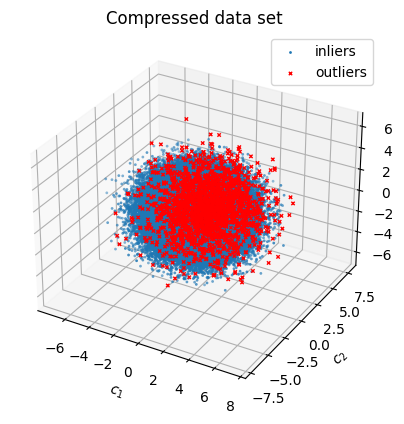

In [24]:
# Plot all the ground truth points together with the predictions
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.title("Compressed data set")
ax.set_xlabel(r'$c_{1}$') ; ax.set_ylabel(r'$c_{2}$') ;ax.set_zlabel(r'$c_{3}$')

# Plot the compressed inliers data points
ax.scatter(X_reduce[y_true == 0, 0], X_reduce[y_true == 0, 1], zs=X_reduce[y_true == 0, 2], s=4, lw=0, label = "inliers")

# outliers
ax.scatter(X_reduce[y_true == 1, 0], X_reduce[y_true == 1, 1], zs=X_reduce[y_true == 1, 2], 
           lw=1, s=6, marker="x", c="red", alpha=1, label = "outliers")
ax.legend()
plt.show();

Partition dataset:

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset, y_true, test_size=0.33, random_state=42)

print(X_train.shape)
print(X_test.shape)

print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(134000, 30)
(66000, 30)
(array([0, 1]), array([132629,   1371]))
(array([0, 1]), array([65390,   610]))


### Model training and prediction

In [26]:
reload(model)
reload(utils)

bm = model.BHAD(contamination = 0.01, nbins = None, verbose=True)

y_pred_train = bm.fit_predict(X_train)   
#scores_train = bm.decision_function(X_train)
scores_train = bm.anomaly_scores


-- Construct Bayesian Histogram-based Anomaly Detector (BHAD) --

Computing Bayes estimate for number of bins per dimension.
Finished 'fit' in 40.2535 secs
Finished 'transform' in 0.0245 secs
Discretize continous features.
One-hot encoding categorical features.
Finished 'fit' in 5.4459 secs
Finished 'transform' in 160.5470 secs
Matrix dimension after one-hot encoding: (134000, 1214)
Fit BHAD on discretized data.
Finished training.
Score input data.
Score input data.


In [27]:
y_pred_test = bm.predict(X_test)
#scores_test = bm.decision_function(X_test)
scores_test = bm.anomaly_scores


Score input data.
Discretize continous features.


Plot score distribution:

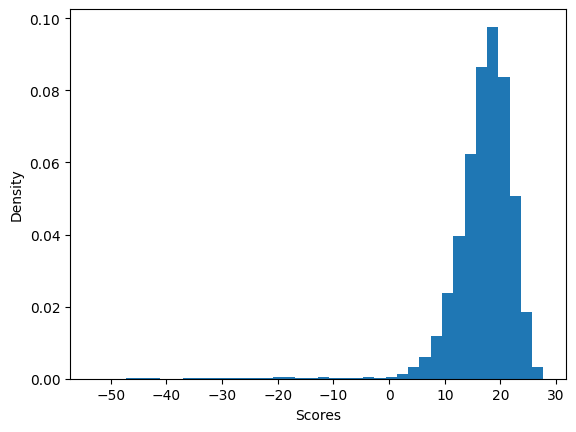

In [11]:
plt.hist(scores_train, density=True, bins=40)  # density=False would make counts
plt.ylabel('Density')
plt.xlabel('Scores');

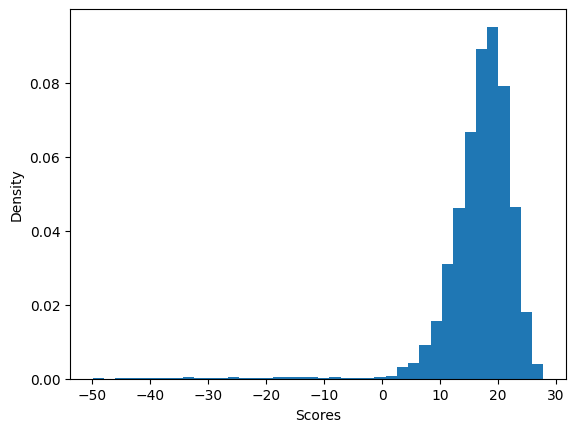

In [12]:
plt.hist(scores_test, density=True, bins=40) 
plt.ylabel('Density')
plt.xlabel('Scores');

In [13]:
from sklearn.metrics import classification_report

# Make comparable to y_true encoding
y_pred_train[y_pred_train == 1] = 0
y_pred_train[y_pred_train == -1] = 1

print(classification_report(y_train, y_pred_train, target_names=['Inlier', 'Outlier']))

              precision    recall  f1-score   support

      Inlier       1.00      1.00      1.00     13268
     Outlier       0.95      0.96      0.95       132

    accuracy                           1.00     13400
   macro avg       0.97      0.98      0.98     13400
weighted avg       1.00      1.00      1.00     13400



In [14]:
# Make comparable to y_true encoding
y_pred_test[y_pred_test == 1] = 0
y_pred_test[y_pred_test == -1] = 1

print(classification_report(y_test, y_pred_test, target_names=['Inlier', 'Outlier']))

              precision    recall  f1-score   support

      Inlier       1.00      1.00      1.00      6527
     Outlier       0.92      0.99      0.95        73

    accuracy                           1.00      6600
   macro avg       0.96      0.99      0.98      6600
weighted avg       1.00      1.00      1.00      6600

